In [79]:
import re
import random
import pandas as pd
import hashlib

In [80]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [81]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Open Source/GitHub,118.473639,59.236820,72.843882,2
VMWare,179.816258,4.181773,17.291646,43
WSL + Kali Linux,286.974193,47.829032,62.694813,6
Azure Compute Gallery,590.741967,14.768549,25.909583,40
C# Basics,809.214806,26.103703,40.519834,31
Azure Private DNS,849.955892,44.734521,68.084970,19
RAG Project,964.644912,60.290307,125.123559,16
Azure AD Authentication,1024.594893,78.814992,183.048144,13
Azure Functions + Visual Studio,1109.795302,85.368869,288.895587,13
Audit Report Tracker (Sharepoint List),1151.269496,104.660863,282.319577,11


# Histogram

sum of ages: ~50167.59


<Axes: >

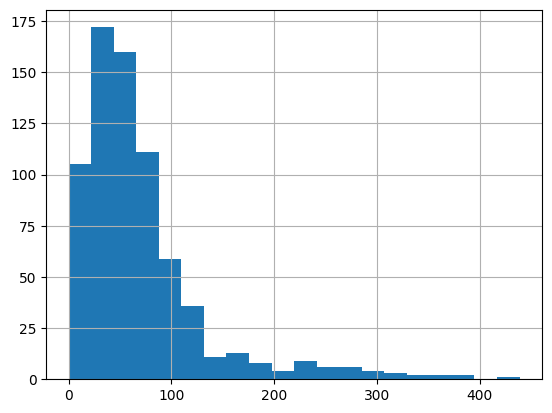

In [82]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [83]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [84]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [85]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [86]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [87]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [88]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [89]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [90]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [91]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [92]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 714
Total card age: 50167.59


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
76,Azure Developer Associate,Which Azure Monitor table holds platform metri...,52fbf976aa2ccee89121f7b5694acfce,438.857661,91.883489,-438.857661,5053.591905,0.354431,0,0,-438.857661
78,Azure Developer Associate,Which Azure Monitor REST API endpoint runs Kus...,081c21867969bfa0dc22e3673aa7e1ba,236.358413,91.883489,-438.857661,5053.591905,0.354431,3,0,-236.358413
171,Azure Developer Associate,Front: What’s the effect of setting maxInterva...,15836064c952b1b5e4cbd598cc88dd9f,167.435687,91.883489,-438.857661,5053.591905,0.354431,6,0,-167.435687
257,Azure Developer Associate,Which Azure storage service supports a user de...,fd19a76de5cbe2ba07dc309378571330,124.463433,91.883489,-438.857661,5053.591905,0.354431,9,0,-124.463433
330,Azure Developer Associate,Which App Service deployment method enables CI...,6dc42c6bb692381c9db51d6ac813936e,96.074916,91.883489,-438.857661,5053.591905,0.354431,12,0,-96.074916
332,Azure Developer Associate,How do you correlate errors from Application I...,d2b1cb71a345cc2e58099a4572434c25,90.519089,91.883489,-438.857661,5053.591905,0.354431,15,0,-90.519089
446,Azure Developer Associate,How can each developer use one key to access m...,24285832dc2df8b6fb01f1b5df9f3541,79.848008,91.883489,-438.857661,5053.591905,0.354431,18,0,-79.848008
445,Azure Developer Associate,How do you set a container group to restart on...,19ef645a0da6a271fc6613c236edeac5,75.791929,91.883489,-438.857661,5053.591905,0.354431,21,0,-75.791929
491,Azure Developer Associate,What Azure CLI command allows CORS from https:...,95d2a75240a646635b69d89fe62896ef,71.851374,91.883489,-438.857661,5053.591905,0.354431,24,0,-71.851374
604,Azure Developer Associate,Which persistence setting minimizes storage co...,80195742cf378c711ab51bf4d8523fb0,68.637451,91.883489,-438.857661,5053.591905,0.354431,27,0,-68.637451


## Card Count

In [93]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [94]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [95]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
76,Azure Developer Associate,Which Azure Monitor table holds platform metri...,52fbf976aa2ccee89121f7b5694acfce,438.857661,91.883489,-438.857661,5053.591905,0.354431,0,0,-438.857661
52,PowerShell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,392.351357,99.928983,-392.351357,3697.372366,0.833332,0,0,-392.351357
72,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,375.121942,98.734056,-375.121942,5134.170936,0.415334,0,0,-375.121942
53,PowerShell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,359.891383,99.928983,-392.351357,3697.372366,0.833332,1,1,-359.891383
36,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,359.099041,83.811341,-359.099041,2011.472187,0.141778,0,0,-359.099041
48,FSLogix,"During a first-time sign-in, FSLogix creates t...",f2d84db5972e92abd44bdb7e0c5686a7,344.808730,76.721293,-344.808730,2608.523978,0.413651,0,0,-344.808730
49,FSLogix,Q: Which format does FSLogix use to store user...,2502a81cff9047e83fa1e04a99225de5,339.446698,76.721293,-344.808730,2608.523978,0.413651,1,1,-339.446698
84,Vocab,"Red Side Story, FForde\nParboil\nPronunciation...",1ee9362f92872e44aac4c6b02749add8,313.788403,64.413311,-313.788403,5217.478154,0.524939,0,0,-313.788403
56,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,308.465076,101.878145,-308.465076,3973.247672,0.360725,0,0,-308.465076
77,Azure Developer Associate,Where do Application Insights telemetry tables...,d5a8469fce507684c17e1dc224588031,308.193025,91.883489,-438.857661,5053.591905,0.354431,1,1,-308.193025


In [96]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Which Azure Monitor table holds platform metri...
hash                   52fbf976aa2ccee89121f7b5694acfce081c21867969bf...
age                                                           1449.83796
subject_mean_age                                              918.834892
subject_highest_age                                         -4388.576609
subject_age_sum                                             50535.919046
head_random_roll                                                3.544307
count                                                                135
n_fold                                                                 0
neg_age                                                      -1449.83796
dtype: object

In [97]:
existing_cards['age'].mean()

70.26272957137498